# `CLEMnet` predictions on RL012
---
#### Overview
* Model for typical results figure and whatnot

In [6]:
# device = cuda.get_current_device()
# device.reset()

In [2]:
import clemnet

In [3]:
from pathlib import Path
import random
from datetime import datetime
from numba import cuda 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from skimage import io, exposure, color
from skimage import img_as_ubyte, img_as_float
from skimage.util import invert, crop
from skimage.transform import resize
from sklearn import preprocessing

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Set GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Set colormap
plt.set_cmap('magma')
plt.close();

# Ignore annoying Futurewarning from `gray2rgba`
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Set ... AUTOTUNE?
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Indirectly enable autocomplete
%config Completer.use_jedi = False

## Organize training data
---

In [5]:
# 20200618_RL012
# --------------
fps_src = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
# fps_src = list(Path('/home/mabels/CLEMnet/data/RL012_blurred/').glob('*/*_*_*.png'))
fps_tgt = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))

# Get DataFrame for training
df_trn = clemnet.get_DataFrame(fps_src, fps_tgt)

# Filter out all but 0th zoom level
df_trn = df_trn.loc[df_trn['zoom'] == 4]

# Filter out a test section
df_trn = df_trn.loc[df_trn['z'] == 1]


df_trn_RL012 = df_trn
pd.set_option('display.max_colwidth', -1)
print(df_trn_RL012.source)

# print(df_trn['zoom'].unique())

ValueError: Columns must be same length as key

In [5]:
# Combine and shuffle DataFrame
df_trn = pd.concat([df_trn_RL012])
df_trn = df_trn.sample(frac=1, random_state=1337).reset_index(drop=True)

# Set source and target filepaths
fps_src = df_trn['source'].values
fps_tgt = df_trn['target'].values

# Preview
out = f"""\
Number of training images... {len(df_trn)}
--------""";print(out)
df_trn.sample(10)

Number of training images... 2760
--------


source  z   y   x  zoom  \
1522  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  1  19  24     0   
1184  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  9  22  15     0   
2721  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  4  25  25     0   
1275  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  3  29  20     0   
2585  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  3  23  34     0   
23    /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  3  23  28     0   
175   /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  3  18  27     0   
277   /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  9  20  32     0   
103   /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  9  24  14     0   
2678  /home/rlane/FMML_DATA/20200618_RL012/2us/lil_E...  3  34  20     0   

                                                 target  
1522  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
1184  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
2721  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
1275  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
2585  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
23    /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
175   /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
277   /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
103   /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...  
2678  /home/rlane/FMML_DATA/20200618_RL012/2us/hoech...

### Create training and validation datasets
First test with very limited dataset size

In [6]:
# Choose validation size
n_validation = int(0.2 * len(df_trn))

# Split into training and validation sets
fps_trn_src = fps_src[:-n_validation]
fps_trn_tgt = fps_tgt[:-n_validation]
fps_val_src = fps_src[-n_validation:]
fps_val_tgt = fps_tgt[-n_validation:]

In [7]:
# Set training parameters
repeat = True
n_repetitions = 4
shape_src = [1024, 1024]
shape_tgt = [256, 256]
augment = True
AUGMENTATIONS = {
    'flip': 1,
    'rotate': 1,
    'crop': 0.,
    'elastic': 0.3,
    'invert': 0.,
    'contrast': 0.3,
    'brightness': 0.3,
    'noise': 0.,
}
pad = False
padding = tf.constant([[16, 16],
                       [16, 16],
                       [ 0,  0]])
batch_size = 16
n_cores = 4

# Create datasets
ds_trn = clemnet.create_dataset(fps_trn_src, fps_trn_tgt, shuffle=False, buffer_size=None,
                                repeat=repeat, n_repetitions=n_repetitions, shape_src=shape_src,
                                shape_tgt=shape_tgt, augment=augment, augmentations=AUGMENTATIONS,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)
ds_val = clemnet.create_dataset(fps_val_src, fps_val_tgt, shuffle=False, buffer_size=None,
                                repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=False,
                                pad=pad, padding=padding, batch=True, batch_size=batch_size,
                                prefetch=True, n_cores=n_cores)

# Get first batch for shape info
batch_EM, batch_FM = next(iter(ds_trn))

print(f"""\
Training dataset size..... {tf.data.experimental.cardinality(ds_trn).numpy()}
Validation dataset size... {tf.data.experimental.cardinality(ds_val).numpy()}
EM image shape............ {batch_EM.shape}
FM image shape............ {batch_FM.shape}""")

2021-12-09 12:21:36.471774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-09 12:21:38.197116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:b1:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2021-12-09 12:21:38.197450: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-09 12:21:38.199748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-09 12:21:38.201816: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-09 12:21:38.202688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.

Training dataset size..... 552
Validation dataset size... 35
EM image shape............ (16, 1024, 1024, 1)
FM image shape............ (16, 256, 256, 1)


### Preview dataset

  0%|          | 0/16 [00:00<?, ?it/s]

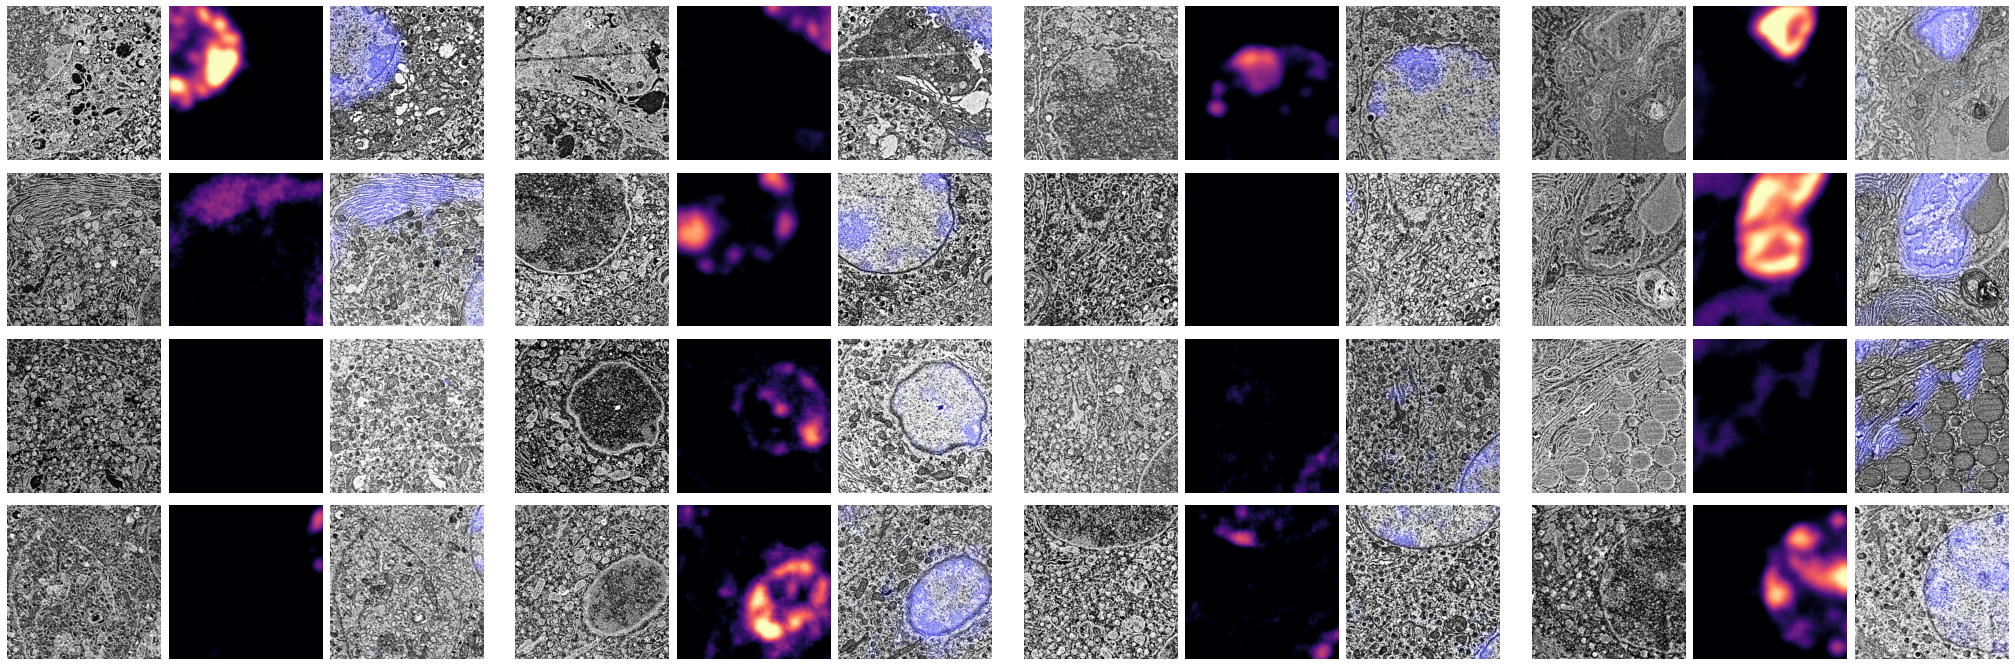

In [8]:
# Set up figure
%matplotlib inline
ncols = 4
nrows = int(np.ceil(batch_size / ncols))
fig = plt.figure(figsize=(ncols*9, nrows*3))
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig,
                       hspace=0.08, wspace=0.05)

# Loop through a batch size worth of images
batch_EM, batch_FM = next(iter(ds_trn))
for i in tqdm(range(batch_size)):

    # Fetch images from batch
    img_EM = batch_EM[i,:,:,0].numpy().astype(np.float32)
    img_FM = batch_FM[i,:,:,0].numpy().astype(np.float32)
    # Upsample to fit EM
    img_FM = resize(img_FM, img_EM.shape)

    # Create CLEM image
    img_EM_ = color.gray2rgba(invert(img_EM), alpha=True)
    img_FM_ = clemnet.colorize(img_FM, clemnet.T_HOECHST)
    img_CLEM = exposure.rescale_intensity(img_EM_+img_FM_, in_range=(0, 1))

    # Set up mini gridspec
    gss = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, wspace=0,
                                           subplot_spec=gs[i])
    ax1 = fig.add_subplot(gss[0])
    ax2 = fig.add_subplot(gss[1])
    ax3 = fig.add_subplot(gss[2])

    # Plot images
    ax1.imshow(img_EM, cmap='gray', vmin=0, vmax=1)
    ax2.imshow(img_FM, cmap='magma', vmin=0, vmax=1)
    ax3.imshow(img_CLEM)

    # Aesthetics
    [ax.axis('off') for ax in [ax1, ax2, ax3]]

## Training
---

In [9]:
%load_ext tensorboard

### Create model
Need better resolution for insulin prediction

In [10]:
def get_model(input_shape=(1024, 1024), crop_=False, crop_width=None):
    """U-net-like convolutional neural network
    Parameters
    ----------
    input_shape : tuple
        Shape of input image data
    crop : bool
        Whether to include a cropping layer
    crop_width : int
        Number of pixels to crop from each border

    Returns
    -------
    model : `keras.Model`
        The model (duh)

    References
    ----------
    [1] U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    [2] Adapted from
        https://github.com/zhixuhao/unet/blob/master/model.py
    """
    # Create input layer
    input_shape = (*input_shape, 1) if len(input_shape) < 3 else input_shape
    inputs = layers.Input(shape=input_shape)

    # Set up keyword arguments for convolutional layers
    kwargs = {
        'activation': 'relu',
        'padding': 'same',
        'kernel_initializer': 'he_normal'
    }

    # Downsampling arm
    # ----------------
    # Block 1
    conv1 = layers.Conv2D(32, 3, **kwargs)(inputs)
    pool1 = layers.MaxPooling2D(2)(conv1)
    # Block 2
    conv2 = layers.Conv2D(64, 3, **kwargs)(pool1)
    pool2 = layers.MaxPooling2D(2)(conv2)
    # Block 3
    conv3 = layers.Conv2D(128, 3, **kwargs)(pool2)
    pool3 = layers.MaxPooling2D(2)(conv3)
    # Block 4
    conv4 = layers.Conv2D(256, 3, **kwargs)(pool3)
    pool4 = layers.MaxPooling2D(2)(conv4)
    # Block 5
    conv5 = layers.Conv2D(512, 3, **kwargs)(pool4)
    pool5 = layers.MaxPooling2D(2)(conv5)
    # Block 6
    conv6 = layers.Conv2D(1024, 3, **kwargs)(pool5)
    pool6 = layers.MaxPooling2D(2)(conv6)

    # Upsampling arm
    # --------------
    # Block 7
    conv7 = layers.Conv2D(1024, 3, **kwargs)(pool6)
    uppp7 = layers.UpSampling2D(2)(conv7)
    # Block 8
    merg8 = layers.concatenate([conv6, uppp7], axis=3)
    conv8 = layers.Conv2D(1024, 3, **kwargs)(merg8)
    uppp8 = layers.UpSampling2D(2)(conv8)
    # Block 9
    merg9 = layers.concatenate([conv5, uppp8], axis=3)
    conv9 = layers.Conv2D(512, 3, **kwargs)(merg9)
    uppp9 = layers.UpSampling2D(2)(conv9)
    # Block 10
    merg10 = layers.concatenate([conv4, uppp9], axis=3)
    conv10 = layers.Conv2D(256, 3, **kwargs)(merg10)
    conv10 = layers.Conv2D(2, 3, **kwargs)(conv10)

    # Additional upsampling
    uppp11 = layers.UpSampling2D(2)(conv10)

    # Output layer
    conv11 = layers.Conv2D(1, 1, activation='sigmoid')(uppp11)
    model = keras.Model(inputs=inputs, outputs=conv11)
    return model

In [11]:
# Get input shape for model
input_shape = batch_EM.shape[1:-1]

# Get model
crop_ = pad
crop_width = 16
model = get_model(input_shape=input_shape,
                  crop_=crop_, crop_width=crop_width)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

### Train

In [12]:
# Check if batch size is appropriate
batch_size_max = clemnet.get_max_batch_size(12, model)
print(f"""\
Current batch size... {batch_size}
Max batch size....... {int(np.floor(batch_size_max))}
Good to go..........? {batch_size <= batch_size_max}""")

Current batch size... 16
Max batch size....... 18
Good to go..........? True


### Compile model

In [13]:
# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[clemnet.PCC_tf, clemnet.ICQ_tf])

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Model
model_name = 'RL012_1024x1024_hoechst'

# Set callbacks
fp_weights = Path(f"./weights/{model_name}_{timestamp}.h5")
fp_logs = Path(f"./logs/{model_name}_{timestamp}")
fp_weights.parent.mkdir(parents=True, exist_ok=True)
callbacks = [
    keras.callbacks.ModelCheckpoint(fp_weights.as_posix(),
                                    save_best_only=True,
                                    save_weights_only=True),
    keras.callbacks.TensorBoard(log_dir=fp_logs.as_posix()),
    keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=15,
                                  verbose=1)
]

out = f"""\
Saving model to... {fp_weights}
Saving logs to.... {fp_logs}"""
print(out)

Saving model to... weights/RL012_1024x1024_hoechst_20211209_122157.h5
Saving logs to.... logs/RL012_1024x1024_hoechst_20211209_122157


2021-12-09 12:21:57.023931: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2021-12-09 12:21:57.023984: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1363] Profiler found 1 GPUs
2021-12-09 12:21:57.026800: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcupti.so.10.1
2021-12-09 12:21:57.184698: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1479] CUPTI activity buffer flushed


## Testing
---

### Create test dataset

In [14]:
xy_maxmin = pd.DataFrame()

##### Choose dataset & zoom_level

In [23]:
# 20200618_RL012
# --------------
# fps_src_FASTEM = list(Path('/home/rlane/FMML_DATA/20210224_FAST-EM_prototype').glob('*/*_*_*.png'))
fps_src_Rl012 = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
# fps_src_FASTEM_mask = list(Path('/home/mabels/CLEMnet/data/FASTEM/masks').glob('*/*_*_*.png'))
# fps_src_FASTEM = list(Path('/home/mabels/CLEMnet/data/FASTEM/masks/0').glob('*/*_*_*.png'))

zoom_level_init = 3 
zoom_level_to = 1

In [40]:
# Get DataFrame for predicting
df_tst = clemnet.get_DataFrame(fps_src_Rl012)

# xy_maxmin for all #i zoom_levels

print(df_tst['zoom'].unique())

for i in df_tst['zoom'].unique():
    df_tst = clemnet.get_DataFrame(fps_src_Rl012)
    df_tst = df_tst.loc[df_tst['zoom'] == i]  
    xy_maxmin[i] = [(df_tst['x'].unique().min() if df_tst['x'].unique().min() != 0 else 1), 
                    df_tst['x'].unique().max(), 
                    (df_tst['y'].unique().min() if df_tst['y'].unique().min() != 0 else 1), 
                    df_tst['y'].unique().max()]

print(xy_maxmin)
# Get DataFrame for predicting
df_tst = clemnet.get_DataFrame(fps_src_Rl012)
df_tst_mask = clemnet.get_DataFrame(fps_src_Rl012)

df_tst = df_tst.loc[df_tst['zoom'] == zoom_level_init]
df_tst_mask = df_tst_mask.loc[df_tst_mask['zoom'] == zoom_level_init]
# Filter out a test section
df_tst = df_tst.loc[(df_tst['z'] != 7)]
df_tst_mask = df_tst_mask.loc[(df_tst_mask['z'] != 7)]

# Filter out outermost rows and columns
# where data is poor or does not exist
b = 0
df_tst_filtered = pd.DataFrame()
df_tst_filtered_mask = pd.DataFrame()

# # Must be done per section, first x, than y
fltr  = pd.DataFrame()

# [[[x0, x1], [y0, y1]]]
fltr_manual = [[[0, xy_maxmin[zoom_level_init][1]], 
                [0, xy_maxmin[zoom_level_init][3]]]]

# Langerhans Island
# -----------------------------------
# fltr_manual = [[[0, 1], [2, 3]]]                # zoom_level = 3
# fltr_manual = [[[2, 6], [9, 12]]]               # zoom_level = 1
# fltr_manual = [[[3, 15], [17, 28]]]             # zoom_level = 0
# fltr_manual = [[[4, 14], [18, 25]]]             # zoom_level = 0
# fltr_manual = [[[7, 8], [24, 25]]]             # zoom_level = 0

# Nucleus in Langerhans Island
# -----------------------------------
# fltr_manual = [[[10 , 11], [27, 28]]]            # zoom_level = 0
# fltr_manual = [[[5, 6], [13, 14]]]              # zoom_level = 1

# Overig
# fltr_manual = [[[8, 10], [8, 10]]]
# fltr_manual = [[[5, 13], [17, 20]]]             # zoom_level = 0

for i, (z, grp) in enumerate(df_tst.groupby('z')):
        
    r = 2 # num of decimals     
#     [ xymaxmin[zoom_level = 0]
#       xymaxmin[zoom_level = 1]
#       xymaxmin[zoom_level = 2]
#       xymaxmin[zoom_level = 3]]
    fltr[str(z)] = [[   [round(((fltr_manual[i][0][0])/(xy_maxmin[zoom_level_init][1]))*xy_maxmin[0][1], r), round((fltr_manual[i][0][1])/(xy_maxmin[zoom_level_init][1])*xy_maxmin[0][1], r)],         [round(((fltr_manual[i][1][0])/(xy_maxmin[zoom_level_init][3])*xy_maxmin[0][3]), r), round(((fltr_manual[i][1][1])/(xy_maxmin[zoom_level_init][3]))*xy_maxmin[0][3], r)]  ],
                    [   [round(((fltr_manual[i][0][0])/(xy_maxmin[zoom_level_init][1]))*xy_maxmin[1][1], r), round((fltr_manual[i][0][1])/(xy_maxmin[zoom_level_init][1])*xy_maxmin[1][1], r)],         [round(((fltr_manual[i][1][0])/(xy_maxmin[zoom_level_init][3])*xy_maxmin[1][3]), r), round(((fltr_manual[i][1][1])/(xy_maxmin[zoom_level_init][3]))*xy_maxmin[1][3], r)]  ],
                    [   [round(((fltr_manual[i][0][0])/(xy_maxmin[zoom_level_init][1]))*xy_maxmin[2][1], r), round((fltr_manual[i][0][1])/(xy_maxmin[zoom_level_init][1])*xy_maxmin[2][1], r)],         [round(((fltr_manual[i][1][0])/(xy_maxmin[zoom_level_init][3])*xy_maxmin[2][3]), r), round(((fltr_manual[i][1][1])/(xy_maxmin[zoom_level_init][3]))*xy_maxmin[2][3], r)]  ],
                        fltr_manual[i]]
    
    print('from zoomlevel', zoom_level_init,'with x0, x1, y0, y1', fltr_manual, 'to zoomlevel:', zoom_level_to, fltr[str(z)][zoom_level_to])
    
    df_tst_filtered = df_tst_filtered.append(grp.loc[(grp['x'] >= grp['x'].min()+b) &\
                                               (grp['y'] >= grp['y'].min()+b) &\
                                               (grp['x'] <= grp['x'].max()-b) &\
                                               (grp['y'] <= grp['y'].max()-b) &\
                                               (grp['x'] >= fltr[str(z)][zoom_level_init][0][0]) &\
                                               (grp['x'] <= fltr[str(z)][zoom_level_init][0][1]) &\
                                               (grp['y'] >= fltr[str(z)][zoom_level_init][1][0]) &\
                                               (grp['y'] <= fltr[str(z)][zoom_level_init][1][1])])    
print()

print(df_tst_filtered.source)
print(df_tst_filtered_mask.source)
pd.set_option('display.max_colwidth', -1)

[3 4 5 6 0 1 2]
   3  4  5  6   0   1   2
0  1  1  1  1   3   1   1
1  5  2  1  0  40  20  10
2  1  1  1  1   3   1   1
3  5  2  1  0  42  21  10
from zoomlevel 3 with x0, x1, y0, y1 [[[0, 5], [0, 5]]] to zoomlevel: 1 [[0.0, 20.0], [0.0, 21.0]]


IndexError: list index out of range

### Dataset preview

In [223]:
def genDiag(nR, nC, valUpper, valDiag, valLower):
    slope = nC / nR
    tbl = np.full((nR, nC), valDiag, dtype=float)
    for r in range(nR):
        tbl[r, 0 : int(round(slope * r, 0))] = valLower
        tbl[r, int(round(slope * (r + 1), 0)) : nC] = valUpper
    return tbl

  0%|          | 0/88 [00:00<?, ?it/s]

min: 0.0 max: 1.0


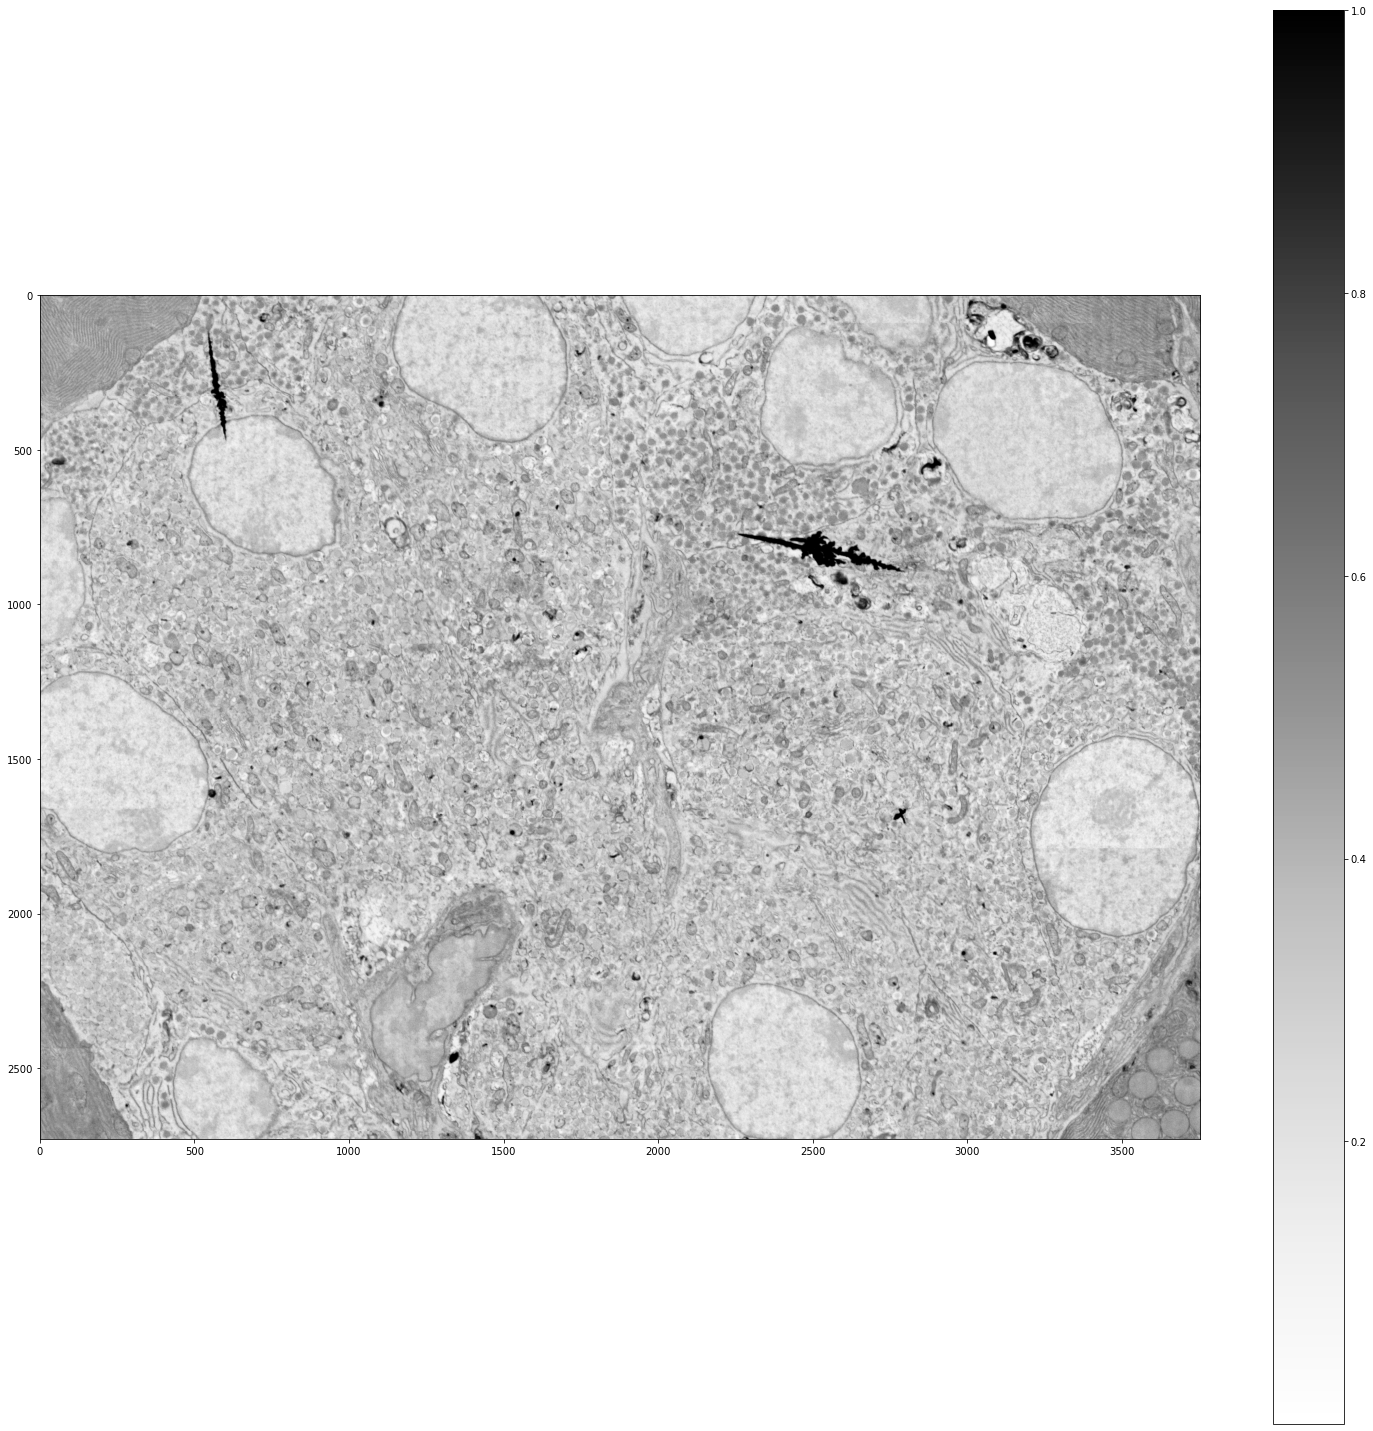

In [224]:
# Make figure
%matplotlib inline
ncols = df_tst_filtered['z'].unique().size
fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(26*ncols, 26),
                         sharex=True, sharey=True, squeeze=False)
axmap = {k:v for k,v in zip(df_tst['z'].unique(), axes.T)}

for z, df_sec in df_tst_filtered.groupby('z'):
    
    # Create dataset for section
    fps_tst_src = df_sec['source']
    ds_section = clemnet.create_dataset(fps_tst_src, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt,
                                        augment=True, augmentations={'invert': True},
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()
    
    # Create empty arrays for full section images
    batch_EM = next(iter(ds_section))   
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])
    section_EM = np.empty(shape)

    # Loop through individual EM 
    for (i, row), (batch_EM) in tqdm(zip(df_sec.iterrows(), ds_section), total=len_ds):
         
        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        

        # Populate section images
#         crop_width = ((0, 0), (0, 0))
#         section_EM[y1:y2, x1:x2] = crop(batch_EM[0,:,:,0], crop_width=crop_width, copy=True)
        section_EM[y1:y2, x1:x2] = batch_EM[0,:,:,0]
#         section_mask[y1:y2, x1:x2] = np.ones(img_OSTEM.shape)
#         section_EM[y1:y2, x1:x2] = (section_EM[y1:y2, x1:x2])*overlay*mask_total[y1:y2, x1:x2] +(1-mask_total[y1:y2, x1:x2])*section_EM[y1:y2, x1:x2]
#         section_EM[y1:y2, x1:x2] = mask_total[y1:y2, x1:x2]
        
#     # Colorize and overlay section images & Plot
#     section_EM = color.gray2rgba(invert(section_EM), alpha=True)
    print('min:', section_EM.min(), 'max:', section_EM.max())
#     section_EM = np.clip(section_EM, 0, 1)
#     print(section_EM.min(), section_EM.max())

    output_shape = [d//3 for d in section_EM.shape[:2]]
    im = axmap[z][0].imshow(resize(section_EM, output_shape), cmap='Greys')
    plt.colorbar(im)
#     axmap[z][1].imshow(resize(section_EM, output_shape), cmap='Greys')

## Make predictions

### Normalizations and Adjustments

In [225]:
def mean_std_adjustments(m0, s0, m1, s1, image):
    std_factor = s1/s0
    mean_adjustment = m1-m0
    image = image+mean_adjustment
    image = tf.image.adjust_contrast(image[:,:,np.newaxis], std_factor)
    image = image.numpy()[:,:,0]
    return image

In [226]:
# Adjustments Training Dataset (preview!)
adjust_blur_tds = True

adjust_sharpness_level = 3.75
adjust_contrast_level = 1.2

# RL012 and FASTEM mu & sigma
std_RL012 = 0.287
std_OSTEM = 0.134
mean_RL012 = 0.462
mean_OSTEM = 0.644

mean_3 = 0
sigma_3 = 1

threshold_mask = True
threshold_val = 0.05

# Adustments Predic Dataset
# everything = 0
# everything = 1
everything = ''

if everything==0:
    adjust_PIL = False
    adjust_invert = False
    adjust_sharpness = False
    adjust_contrast = False
    adjust_mean_std = False
    adjust_clipping = False
elif everything==1:
    adjust_PIL = True
    adjust_invert = True
    adjust_sharpness = True
    adjust_contrast = True
    adjust_mean_std = True
    adjust_clipping = True
else:
    adjust_PIL = True
    adjust_invert = True
    adjust_sharpness = True
    adjust_contrast = True
    adjust_mean_std = True
    adjust_clipping = True
    
preview_prediction = False

In [227]:
# Select Filepath Prediction Dataset
# --------------------------------------
fps_OSTEM = list(Path('/home/rlane/FMML_DATA/20210224_FAST-EM_prototype').glob('*/*_*_*.png'))
fps_BSE = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/lil_EM_2us_montaged/').glob('*/*_*_*.png'))
fps_BSE_blurred = list(Path('/home/mabels/CLEMnet/data/RL012_blurred/').glob('*/*_*_*.png'))
fps_FM = list(Path('/home/rlane/FMML_DATA/20200618_RL012/2us/hoechst_correlated/').glob('*/*_*_*.png'))

df_BSE_FM = clemnet.get_DataFrame(fps_BSE, fps_FM)
fps_BSE = df_BSE_FM.source
fps_FM = df_BSE_FM.target

#521 #628 #1827#1916
fp_OSTEM = fps_OSTEM[1916]
num = 999
fp_BSE = fps_BSE[num]
fp_BSE_blurred = fps_BSE_blurred[num]
fp_FM = fps_FM[num]
# 1023

img_OSTEM = img_as_float(io.imread(fp_OSTEM))
img_BSE = img_as_float(io.imread(fp_BSE))
img_BSE_blurred = img_as_float(io.imread(fp_BSE_blurred))
img_FM = img_as_float(io.imread(fp_FM))


# Image PIL enhancements: Sharpness, Contrast, Resizing
# ------------------------------------------------
if adjust_PIL:
    im = Image.open(fp_OSTEM)
    if adjust_invert:
        im = ImageOps.invert(im)
    im.thumbnail((200,200),Image.ANTIALIAS)
    if adjust_sharpness:
        im = ImageEnhance.Sharpness(im)
        im = im.enhance(adjust_sharpness_level)
    if adjust_contrast:
        im = ImageEnhance.Contrast(im)
        im = im.enhance(adjust_contrast_level)
    # im = ImageEnhance.Brightness(im)
    # im = im.enhance(0.0)
    img_OSTEM = np.asarray(im)/255
    # im = Image.fromarray(np.uint8(im))

# Mean & Std Adjustments + Clipping
# ------------------------------------------------
mean_OSTEM = img_OSTEM.mean()
mean_BSE = img_BSE.mean()
std_OSTEM = img_OSTEM.std()
std_BSE = img_BSE.std()
if adjust_mean_std:
    img_OSTEM = mean_std_adjustments(mean_OSTEM, std_OSTEM, mean_BSE, std_BSE, img_OSTEM)
if adjust_clipping:
    img_OSTEM = np.clip(img_OSTEM, 0, 1)
    
# Blur Adjustments Training Dataset
# ------------------------------------------------    
if adjust_blur_tds:
    im = Image.open(fp_BSE)
    im = im.filter(ImageFilter.GaussianBlur(5))
    img_BSE_blurred = np.asarray(im)/255

### Load Weights and make Prediction


In [228]:
# Make predictions
img_OSTEM = resize(img_OSTEM, (1024,1024))
img_OSTEM_predic = img_OSTEM[np.newaxis,:,:,np.newaxis]

# Load weights
fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel1_20211118_003159.h5')
model.load_weights(fp_weights.as_posix())
predictions_raw = model.predict(img_OSTEM_predic, verbose=1)

# Load weights
fp_weights = Path('./weights/RL012_1024x1024_hoechst_zoomlevel_1_blurred_20211124_103409.h5')
model.load_weights(fp_weights.as_posix())
predictions_blurred = model.predict(img_OSTEM_predic, verbose=1)

(1, 1024, 1024, 1)
1/1 [==============================] - 0s 1ms/step


### Preview predictions

In [229]:
if preview_prediction:
    img_PR = predictions_raw[0, :, :, 0].astype(np.float32)                   # (256, 256)
    img_PR_blurred = predictions_blurred[0, :, :, 0].astype(np.float32)       # (256, 256)
    # # Upsample to fit EM
    img_PR = resize(img_PR, (1024,1024))
    img_PR_blurred = resize(img_PR_blurred, (1024,1024))

    # Create PREM & PREM_blurred images
    img_BSE_ = color.gray2rgba(img_BSE, alpha=True)
    img_BSE_blurred_ = color.gray2rgba(img_BSE_blurred, alpha=True)
    img_OSTEM_ = color.gray2rgba(img_OSTEM, alpha=True)

    img_FM_ = clemnet.colorize(img_FM, clemnet.T_HOECHST)
    img_PR_ = clemnet.colorize(img_PR, clemnet.T_HOECHST)
    img_PR_blurred_ = clemnet.colorize(img_PR_blurred, clemnet.T_HOECHST)

    img_CLEM = exposure.rescale_intensity(img_BSE_+img_FM_, in_range=(0, 1))
    img_CLEM_blurred = exposure.rescale_intensity(img_BSE_blurred_+img_FM_, in_range=(0, 1))
    img_PREM = exposure.rescale_intensity(img_OSTEM_+img_PR_, in_range=(0, 1))
    img_PREM_blurred = exposure.rescale_intensity(img_OSTEM_+img_PR_blurred_, in_range=(0, 1))

    #create hists
    hist_BSE, bins_BSE = exposure.histogram(img_BSE)
    hist_OSTEM, bins_OSTEM = exposure.histogram(img_OSTEM)

    # fig 1. RL012 - raw
    # ------------------------------------------------
    fig, axes = plt.subplots(ncols=4, figsize=(14, 6))
    im1 = axes[0].imshow(img_BSE, cmap='Greys_r')
    im2 = axes[1].imshow(img_OSTEM, cmap='Greys_r')
    im3 = axes[2].imshow(img_BSE_blurred, cmap='Greys_r')
    im4 = axes[3].imshow(img_OSTEM, cmap='Greys_r')
    axes[0].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, Raw")
    axes[1].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, CLEM")
    axes[2].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, Blurred")
    axes[3].title.set_text(F"OSTEM, ZL: {zoom_level_init}, Adjusted")

    for i, ax in enumerate(axes):
        ax.axis('off')
        div = make_axes_locatable(ax)
        cax = div.append_axes('left', size='5%', pad=0.4)
        fig.colorbar([im1, im2, im3, im4][i], cax=cax, orientation='vertical')


    # 2. 
    # ------------------------------------------------    
    fig, axes = plt.subplots(ncols=4, figsize=(14, 6))
    im1 = axes[0].imshow(img_CLEM, cmap='Greys_r')
    im2 = axes[1].imshow(img_PREM, cmap='Greys_r')
    im3 = axes[2].imshow(img_CLEM_blurred, cmap='Greys_r')
    im4 = axes[3].imshow(img_PREM_blurred, cmap='Greys_r')
    axes[0,0].title.set_text('OSTEM, Adjusted')
    axes[1].title.set_text('OSTEM, PREM (BSE-RL012-Raw)')
    axes[2].title.set_text(F"BSE-RL012, ZL: {zoom_level_init}, Blurred, CLEM")
    axes[3].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (BSE-RL012-Blurred)")

    for i, ax in enumerate(axes):
        ax.axis('off')
        div = make_axes_locatable(ax)
        cax = div.append_axes('left', size='5%', pad=0.4)
        fig.colorbar([im1, im2, im3, im4][i], cax=cax, orientation='vertical')

    print()
    print('BSE Mean:', img_BSE.mean(), 'BSE Std:', img_BSE.std())
    print('OSTEM Mean:', img_OSTEM.mean(), 'OSTEM Std:', img_OSTEM.std())
    print()
    print('Inverted:            ', adjust_invert)
    print('Sharpness:           ', adjust_sharpness)
    print('Contrast:            ', adjust_contrast)
    print('Mean & Std:          ', adjust_mean_std)
    print('Clipping:            ', adjust_clipping)

### Full section prediction

In [231]:
# print('BSE Mean:', img_BSE.mean(), 'BSE Std:', img_BSE.std())
# print('OSTEM Mean:', img_OSTEM.mean(), 'OSTEM Std:', img_OSTEM.std())
print()
print('Inverted:            ', adjust_invert)
print('Sharpness:           ', adjust_sharpness,'(level:',adjust_sharpness_level,')')
print('Contrast:            ', adjust_contrast,'(level:',adjust_contrast_level,')')
print('Mean & Std:          ', adjust_mean_std)
print('Clipping:            ', adjust_clipping)
print()
print('Threshold:            ', threshold_val)

# Make figure
%matplotlib widget
# ncols = df_tst_filtered['z'].unique().size
# fig, axes = plt.subplots(ncols=ncols, nrows=3, figsize=(6*ncols, 12),
#                          sharex=True, sharey=True, squeeze=False)
# axmap = {k:v for k,v in zip(df_tst_filtered['z'].unique(), axes.T)}

for z, df_sec in df_tst_filtered.groupby('z'):

    # Create dataset for section
    fps_src = df_sec['source']

    ds_section = clemnet.create_dataset(fps_src, shuffle=False, buffer_size=None,
                                        repeat=False, shape_src=shape_src, shape_tgt=shape_tgt, augment=True, augmentations={'invert': True},
                                        pad=pad, padding=padding, batch=True, batch_size=1,
                                        prefetch=True, n_cores=n_cores)
    len_ds = tf.data.experimental.cardinality(ds_section).numpy()

    # Create empty arrays for full section images
    batch_EM = next(iter(ds_section))
    shape = ((df_sec['y'].max()-df_sec['y'].min() + 1) * batch_EM.shape[1],
             (df_sec['x'].max()-df_sec['x'].min() + 1) * batch_EM.shape[2])

    section_EM = np.empty(shape)
    section_EM_blurred = np.empty(shape)
    section_PR = np.empty(shape)
    section_mask = np.empty(shape)
    section_PR_thres_1 = np.empty(shape)
    section_PR_thres_2 = np.empty(shape)

    # Loop through individual EM and FM tiles
    for (i, row), (batch_EM) in tqdm(zip(df_sec.iterrows(), ds_section),
                                               total=len_ds):
        
        file_name_tile = fps_src[i].rsplit('/', 1)[-1]
        fps_src_mask = "/home/mabels/CLEMnet/data/FASTEM/masks/"+ str(z) +"/" + file_name_tile
        img_mask = Image.open(fps_src_mask)
        img_mask = np.asarray(img_mask)/255
        img_mask = img_mask[:,:,0]*-1+1
        
        
        img_OSTEM = batch_EM[0,:,:,0].numpy()
        img_BSE_blurred = img_as_float(io.imread(fps_BSE_blurred[i]))
        
        # Image PIL enhancements: Sharpness, Contrast, Resizing
        # ------------------------------------------------
        if adjust_PIL:
            fp_OSTEM = fps_OSTEM[i]
            im = Image.open(fp_OSTEM)

            if adjust_invert:
                im = ImageOps.invert(im)
            im.thumbnail((200,200),Image.ANTIALIAS)
            if adjust_sharpness:
                im = ImageEnhance.Sharpness(im)
                im = im.enhance(adjust_sharpness_level)
            if adjust_contrast:
                im = ImageEnhance.Contrast(im)
                im = im.enhance(adjust_contrast_level)
            # im = ImageEnhance.Brightness(im)
            # im = im.enhance(0.0)
            img_OSTEM = np.asarray(im)/255
            img_OSTEM = resize(img_OSTEM, (1024,1024))

        # Mean & Std Adjustments + Clipping
        # ------------------------------------------------
        if adjust_mean_std:
            img_OSTEM = mean_std_adjustments(mean_OSTEM, std_OSTEM, mean_RL012, std_RL012, img_OSTEM)
        if adjust_clipping:
            img_OSTEM = np.clip(img_OSTEM, 0, 1)
        
        # Make prediction
        img_OSTEM_predic = img_OSTEM[np.newaxis,:,:,np.newaxis]
        prediction = model.predict(img_OSTEM_predic, verbose=0)

        pred = prediction[0,:,:,0]
        pred_threshold_1 = prediction[0,:,:,0]
        pred_threshold_2 = prediction[0,:,:,0]
        
        
        # Threshold value for mask
        if threshold_mask:
            pred_threshold_1 = np.zeros((256, 256)) + pred*(pred > threshold_val)
            pred_threshold_2 = np.zeros((256, 256)) + (pred > threshold_val)
        
        # Get indices to populate section images
        x1 = (df_sec.loc[i, 'x'] - df_sec['x'].min()) * shape_src[1]
        y1 = (df_sec.loc[i, 'y'] - df_sec['y'].min()) * shape_src[0]
        x2 = (df_sec.loc[i, 'x'] - df_sec['x'].min() + 1) * shape_src[1]
        y2 = (df_sec.loc[i, 'y'] - df_sec['y'].min() + 1) * shape_src[0]
        
        # Populate section images
        section_EM[y1:y2, x1:x2] = img_OSTEM
        section_EM_blurred[y1:y2, x1:x2] = img_BSE_blurred
        section_PR[y1:y2, x1:x2] = resize(pred, batch_EM.shape[1:3])
        section_mask[y1:y2, x1:x2] = img_mask
        section_mask_overlay = (section_mask)*section_PR
        
        section_PR_thres_1[y1:y2, x1:x2] = resize(pred_threshold_1, batch_EM.shape[1:3])
        section_mask_overlay_thres_1 = (section_mask)*section_PR_thres_1
        
        section_PR_thres_2[y1:y2, x1:x2] = resize(pred_threshold_2, batch_EM.shape[1:3])
        section_mask_overlay_thres_2 = (section_mask)*section_PR_thres_2
        
    # Colorize and overlay section images
    section_PR_ = clemnet.colorize(section_PR/section_PR.max(), T=clemnet.T_HOECHST)
    section_EM_ = color.gray2rgba(section_EM, alpha=True)
    section_PRED = exposure.rescale_intensity(section_EM_ + section_PR_, in_range=(0, 1))
    
    section_PR_thres_1_ = clemnet.colorize(section_PR_thres_1/section_PR_thres_1.max(), T=clemnet.T_HOECHST)
    section_PRED_thres_1 = exposure.rescale_intensity(section_EM_ + section_PR_thres_1_, in_range=(0, 1))
    
    section_PR_thres_2_ = clemnet.colorize(section_PR_thres_2/section_PR_thres_2.max(), T=clemnet.T_HOECHST)
    section_PRED_thres_2 = exposure.rescale_intensity(section_EM_ + section_PR_thres_2_, in_range=(0, 1)) 
    
    # Plot
    output_shape = [d//3 for d in section_EM.shape[:2]] 
    fig, axmap = plt.subplots(nrows = 3, ncols=4, figsize=(18, 16))
#     im1 = axmap[0, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[0, 0].imshow(resize(section_PRED, output_shape))
    im3 = axmap[0, 1].imshow(resize(section_PR, output_shape), cmap='magma_r')
    im4 = axmap[0, 2].imshow(resize(section_mask, output_shape), cmap='Greys')
    im5 = axmap[0, 3].imshow(resize(section_mask_overlay, output_shape), cmap='Greys')
    
#     im1 = axmap[1, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[1, 0].imshow(resize(section_PRED_thres_1, output_shape))
    im3 = axmap[1, 1].imshow(resize(section_PR_thres_1, output_shape), cmap='magma_r')
    im4 = axmap[1, 2].imshow(resize(section_mask, output_shape), cmap='Greys')
    im5 = axmap[1, 3].imshow(resize(section_mask_overlay_thres_1, output_shape), cmap='Greys')
    
#     im1 = axmap[2, 0].imshow(resize(section_EM, output_shape), cmap='Greys_r')
    im2 = axmap[2, 0].imshow(resize(section_PRED_thres_2, output_shape))
    im3 = axmap[2, 1].imshow(resize(section_PR_thres_2, output_shape), cmap='magma_r')
    im4 = axmap[2, 2].imshow(resize(section_mask, output_shape), cmap='Greys')
    im5 = axmap[2, 3].imshow(resize(section_mask_overlay_thres_2, output_shape), cmap='Greys')

#     axmap[0, 0].title.set_text(F"OSTEM, ZL: {zoom_level_init}, Adjusted")
#     axmap[0, 1].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (trained on BSE-RL012-Blurred)")
#     axmap[0, 2].title.set_text(F"OSTEM, ZL: {zoom_level_init}, PREM (trained on BSE-RL012-Blurred)")
# # #     # Save
# # #     fp = Path(f'RL010_S{z:03d}_CLEM.png')
# # #     io.imsave(fp.as_posix(), section_CLEM)
# # #     fp = Path(f'RL010_S{z:03d}_PRED.png')
# # #     io.imsave(fp.as_posix(), section_PRED)

# print(threshold,round(threshold_val/pred.max()*100,0),'%'))



Inverted:             True
Sharpness:            True (level: 3.75 )
Contrast:             True (level: 1.2 )
Mean & Std:           True
Clipping:             True

Threshold:             0.05


  0%|          | 0/88 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [190]:
a = sum(sum(section_mask_overlay))
b = sum(sum(section_PR))
overlap = round(a/b*100,1)

print('Raw pred  Overlap:',overlap,'%')

a = sum(sum(section_mask_overlay_thres_1))
b = sum(sum(section_PR_thres_1))
overlap = round(a/b*100,1)

print('Threshold Overlap:',overlap,'%')

a = sum(sum(section_mask_overlay_thres_2))
b = sum(sum(section_PR_thres_2))
overlap = round(a/b*100,1)

print('Threshold Overlap:',overlap,'%')


Raw pred  Overlap: 52.4 %
Threshold Overlap: 73.8 %
Threshold Overlap: 73.9 %
